### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 # corrente indicada pelo catálogo
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 352.0 W
Pon = 242.58162605469767 W
Poff = 109.41837394530232 W
Check: True
daily total: P = 48.71069610325876 W, t = 24.0 h
daily on: P = 242.58162605469767 W, t = 10.941338883884528 h
daily off: P = 109.41837394530232 W, t = 13.058661116115472 h
duty cycle: 45.58891201618553 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 35558.808155378894,
 'E_anualy': 426705.69786454673,
 'E_hourly': 48.71069610325876,
 'E_daily': 1169.0567064782103,
 'E_minutely': 0.8118449350543127,
 'E_secondly': 0.013530748917571878,
 'I_nominal': 1.6,
 'P_nominal': 352.0,
 'P_nominal_avg': 242.5816260546977,
 'on_to_off_factor': 0.6891523467463002,
 'P_on': 242.58162605469767,
 'P_off': 109.41837394530232,
 't_daily': 24.0,
 'P_daily': 48.71069610325876,
 't_on': 10.941338883884528,
 't_off': 13.058661116115472,
 'duty_cycle': 0.45588912016185534}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01,27.765000
2019-01-02,27.937500
2019-01-03,30.645833
2019-01-04,24.945833
2019-01-05,23.900000
...,...
2019-12-27,26.429167
2019-12-28,26.508333
2019-12-29,26.920833


,ta
count,365.000000
mean,21.810000
std,3.636444
min,11.531818
25%,19.454167
50%,22.029167
75%,24.325000
max,30.729167


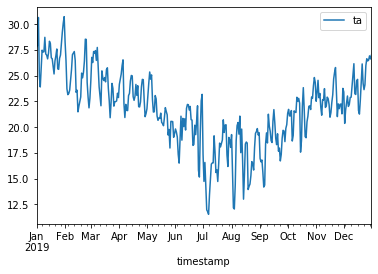

In [3]:
ta_df = pd.read_csv(
    'data/ambient_temperature_daily.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [4]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

In [5]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_daily'] * df['ta'] / df['ta'].mean() / 1000 # kwh
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    hours_per_day = 24
    df['P'] = df['E'] / hours_per_day
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
    })
    if verbose:
        display(df.describe())
    if plot:
        plt.Figure(figsize=(20, 10))
        plt.plot(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()
    
    output_filename = f"data/0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename)
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1,2,3,4,5,6,7,8,9]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True)

,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.932316,110.689073,0.038846,220.153060,0.000176,5.257476
std,3.636444,0.203317,58.781382,0.008472,1.407200,0.000039,0.769345
min,11.531818,0.448381,0.782252,0.018683,217.525271,0.000086,4.038166
25%,19.454167,0.783608,62.687305,0.032650,218.955005,0.000148,4.691697
50%,22.029167,0.932419,114.077668,0.038851,220.142744,0.000177,5.064253
75%,24.325000,1.060392,157.691632,0.044183,221.361451,0.000201,5.887714
max,30.729167,1.565154,215.232446,0.065215,222.591485,0.000297,7.259193


Done: the data for the sensor id 0 was saved to: data/0_sensor_0_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.934190,111.287839,0.038925,220.154511,0.000177,5.263327
std,3.636444,0.208037,58.932778,0.008668,1.410451,0.000039,0.798002
min,11.531818,0.474933,0.860543,0.019789,217.573296,0.000089,4.021206
25%,19.454167,0.786048,63.571186,0.032752,218.933343,0.000148,4.657797
50%,22.029167,0.917968,115.094386,0.038249,220.133822,0.000174,5.080713
75%,24.325000,1.079493,158.610506,0.044979,221.374958,0.000204,5.812105
max,30.729167,1.497418,215.665241,0.062392,222.521802,0.000285,7.264317


Done: the data for the sensor id 1 was saved to: data/0_sensor_1_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.907276,108.623061,0.037803,220.152848,0.000172,5.257202
std,3.636444,0.200720,57.231996,0.008363,1.409652,0.000038,0.764270
min,11.531818,0.408819,0.827550,0.017034,217.534214,0.000078,4.018003
25%,19.454167,0.757840,62.038392,0.031577,218.942467,0.000143,4.679784
50%,22.029167,0.889819,112.770617,0.037076,220.196074,0.000169,5.090794
75%,24.325000,1.050416,154.734908,0.043767,221.392373,0.000199,5.769403
max,30.729167,1.405845,209.451963,0.058577,222.591405,0.000268,7.244280


Done: the data for the sensor id 2 was saved to: data/0_sensor_2_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.893976,107.055253,0.037249,220.153314,0.000169,5.250180
std,3.636444,0.196088,56.555920,0.008170,1.410134,0.000037,0.756838
min,11.531818,0.415518,0.756856,0.017313,217.576685,0.000079,4.034348
25%,19.454167,0.752395,60.581228,0.031350,218.942410,0.000143,4.660750
50%,22.029167,0.886083,111.164466,0.036920,220.129920,0.000167,5.070002
75%,24.325000,1.015140,152.676137,0.042297,221.398721,0.000192,5.783304
max,30.729167,1.458837,206.381356,0.060785,222.590251,0.000277,7.289315


Done: the data for the sensor id 3 was saved to: data/0_sensor_3_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.913928,109.940822,0.038080,220.149900,0.000173,5.274080
std,3.636444,0.195264,58.292214,0.008136,1.407745,0.000037,0.762038
min,11.531818,0.426542,0.596865,0.017773,217.532151,0.000081,4.076172
25%,19.454167,0.770092,61.565526,0.032087,218.938588,0.000146,4.698990
50%,22.029167,0.912495,114.247393,0.038021,220.146285,0.000173,5.122272
75%,24.325000,1.050408,156.701165,0.043767,221.384041,0.000199,5.799342
max,30.729167,1.406641,210.987459,0.058610,222.573093,0.000269,7.228370


Done: the data for the sensor id 4 was saved to: data/0_sensor_4_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.926034,111.543523,0.038585,220.152134,0.000175,5.271350
std,3.636444,0.211475,58.486274,0.008811,1.406840,0.000040,0.779320
min,11.531818,0.462432,0.837641,0.019268,217.543983,0.000089,4.036173
25%,19.454167,0.764096,63.738139,0.031837,218.943083,0.000144,4.657747
50%,22.029167,0.907349,115.899447,0.037806,220.167714,0.000172,5.069338
75%,24.325000,1.079887,158.386302,0.044995,221.359161,0.000205,5.815003
max,30.729167,1.600141,213.782294,0.066673,222.598288,0.000302,7.287519


Done: the data for the sensor id 5 was saved to: data/0_sensor_5_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.913575,109.060293,0.038066,220.151023,0.000173,5.251231
std,3.636444,0.197791,58.150975,0.008241,1.405832,0.000037,0.761676
min,11.531818,0.402888,0.556169,0.016787,217.560834,0.000077,4.052815
25%,19.454167,0.770339,60.981717,0.032097,218.948394,0.000145,4.717542
50%,22.029167,0.910143,113.255047,0.037923,220.149805,0.000172,4.993939
75%,24.325000,1.047862,155.432085,0.043661,221.382272,0.000199,5.808701
max,30.729167,1.549296,210.906018,0.064554,222.569365,0.000292,7.244255


Done: the data for the sensor id 6 was saved to: data/0_sensor_6_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.901498,108.369057,0.037562,220.150628,0.000171,5.248873
std,3.636444,0.217322,56.512652,0.009055,1.408158,0.000041,0.764689
min,11.531818,0.381716,0.806514,0.015905,217.569712,0.000073,4.030941
25%,19.454167,0.743238,63.081726,0.030968,218.944075,0.000140,4.645189
50%,22.029167,0.883983,112.255084,0.036833,220.147674,0.000167,5.085584
75%,24.325000,1.024706,153.207168,0.042696,221.384427,0.000195,5.798251
max,30.729167,1.483377,208.117897,0.061807,222.545855,0.000282,7.274052


Done: the data for the sensor id 7 was saved to: data/0_sensor_7_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.918996,109.374853,0.038292,220.154561,0.000174,5.261156
std,3.636444,0.207611,57.670068,0.008650,1.408666,0.000039,0.757195
min,11.531818,0.454941,0.892049,0.018956,217.581231,0.000087,4.013943
25%,19.454167,0.760554,62.324225,0.031690,218.952437,0.000144,4.701074
50%,22.029167,0.897608,112.644705,0.037400,220.147577,0.000170,5.098090
75%,24.325000,1.058667,155.567200,0.044111,221.400111,0.000201,5.764439
max,30.729167,1.438294,212.157628,0.059929,222.532899,0.000270,7.245353


Done: the data for the sensor id 8 was saved to: data/0_sensor_8_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.810000,0.918292,110.461999,0.038262,220.153219,0.000174,5.259903
std,3.636444,0.206746,58.272967,0.008614,1.409060,0.000039,0.762976
min,11.531818,0.391192,0.598937,0.016300,217.559332,0.000073,4.037379
25%,19.454167,0.764506,62.358112,0.031854,218.946502,0.000145,4.716025
50%,22.029167,0.917036,115.669899,0.038210,220.182219,0.000174,5.083471
75%,24.325000,1.059025,157.489434,0.044126,221.412826,0.000200,5.757645
max,30.729167,1.498182,211.994993,0.062424,222.550267,0.000285,7.071041


Done: the data for the sensor id 9 was saved to: data/0_sensor_9_db.csv


# Gerando o perfil termico de alta frequencia

,ti
2020-01-01 00:00:00,0.971145
2020-01-01 00:00:01,0.978773
2020-01-01 00:00:02,0.988729
2020-01-01 00:00:03,0.966777
2020-01-01 00:00:04,0.992341
...,...
2020-01-01 23:59:55,0.931676
2020-01-01 23:59:56,0.943874
2020-01-01 23:59:57,0.933835
2020-01-01 23:59:58,0.978335


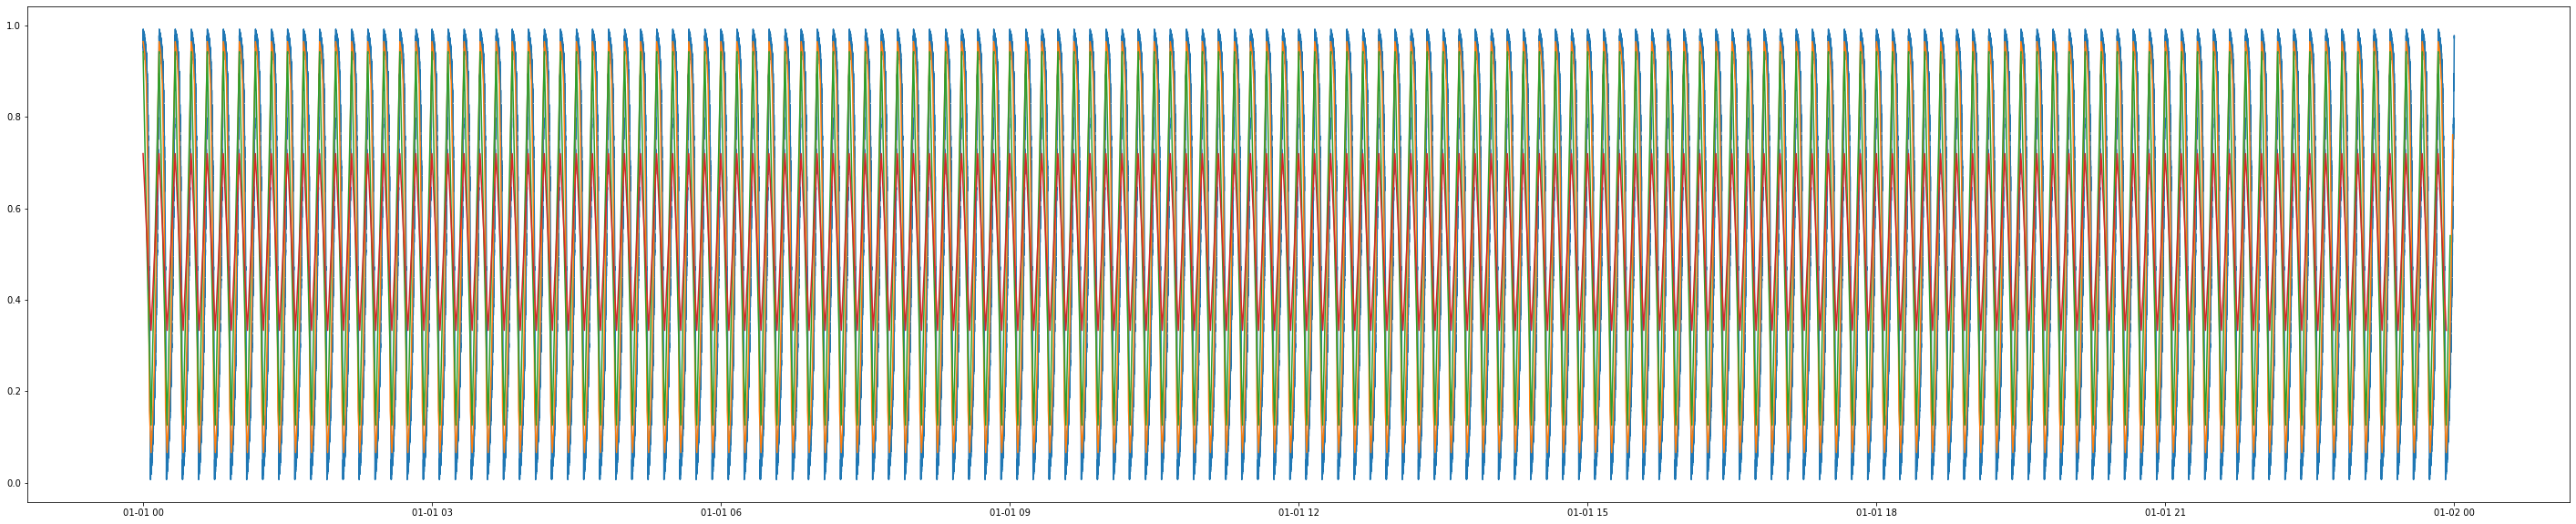

In [14]:
from scipy import signal

def get_sinal_profile(duty_cycle, samples_per_period, noise_level=0.05):
#     triangle = (1 -signal.sawtooth(2 * np.pi * freq * time, width=duty_cycle))*0.5
    freq = 1
    time = np.arange(0, 1, 1/samples_per_period)
    l = int(len(time)*duty_cycle)
    exp = time * 0
    exp[:l] = 1 -np.exp(time / 0.09)[len(time)-l:]
    exp[:l] /= max(abs(exp))
    exp[:l] += 1
    exp[l:] = 0.1*np.exp(time / 0.2)[l:] -1
    exp[l:] /= max(abs(exp[l:]))
    exp -= min(exp)
    exp /= max(exp)
    return (1-noise_level)*exp + noise_level*(1 -np.random.rand(len(exp)))

def generate_signal(sensor, verbose=False, plot=False):

    # 60 samples por 10 minutos = 600 samples
    samples = 600
    profile = get_sinal_profile(sensor['duty_cycle'], samples_per_period=samples)

    # 1 dia tem 24 * 60 minutos, se temos 1  ciclo a cada 10 minutos, temos 24 * 60 / 10 para 1 dia
    cycles = int(24 * 60 / 10)
    df_ti = pd.DataFrame(
        index=pd.date_range(start='2020-01-01 00:00:00', periods=cycles*samples, freq='s'),
        data={'ti': np.tile(profile, cycles)}
    )
    if verbose:
        display(df_ti)

    if plot:
        plt.figure(figsize=(50,10))
        plt.plot(df_ti);  # 1 seg
        plt.plot(df_ti.resample('1T').mean())  # 1 min
        plt.plot(df_ti.resample('2.5T').mean())  # 2.5 min
        plt.plot(df_ti.resample('5T').mean())  # 5 min
        
    return df_ti
    
generate_signal(example, verbose=True, plot=True)

# agora podemos multiplicar esse formato pela temperatura interna média de um dataset de menor frequência